v1 

ライブラリのインポート

In [32]:
# ライブラリのインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

load_dotenv()


#LangchainのAPIを渡す
os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

#GPTのAPIを渡す
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#TavilyのAPIを渡す
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


出力の型を定義

In [33]:
class OutputArticle(BaseModel):
    title: str = Field(description="記事のタイトル")
    main_text: str = Field(description="記事の中身")

LLMの定義

In [34]:
#ツールを利用するエージェント
#ChatOpenAIでチャットモデルを渡す（モデルは変更できる）
model = ChatOpenAI(model="gpt-4o-mini")

# Tavilyの定義　max_results:何件文の検索結果を保持するか
search = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True
)
tools = [search]

agent_executor = create_react_agent(model, tools)

In [35]:
#記事作成を行うエージェント
system_template = '''
あなたは記事作成を行うエージェントです。これから与えられる##検索結果を用いて、##コンテンツについての記事を日本語で作成してください

##検索結果
{search_result}

##コンテンツ
{content}

'''

extract_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", system_template),
    ]
)
extract_trends = model.with_structured_output(
    OutputArticle
)
trend_extractor = extract_prompt | extract_trends


グラフの作成

In [36]:
class State(TypedDict):
    content: str #ユーザーが入力した記事の内容
    search_result: str #LLMが調査を行った結果を格納
    title: str #生成された記事のタイトル
    main_text:str #生成された記事の内容

In [37]:
def search_agent(state: State):
    response = agent_executor.invoke({"messages": [{"role": "user", "content": f"{state['content']}について調査をして、まとめてください"}]})
    state["search_result"] = response["messages"][-1].content
    return state

def generate_article(state: State):
    response = trend_extractor.invoke(state)
    state["title"] = response.title
    state["main_text"] = response.main_text
    return state

In [38]:
workflow = StateGraph(State)

workflow.add_node("search_agent", search_agent)
workflow.add_node("generate_article", generate_article)

workflow.add_edge(START, "search_agent")
workflow.add_edge("search_agent", "generate_article")
workflow.add_edge("generate_article", END)

app = workflow.compile()


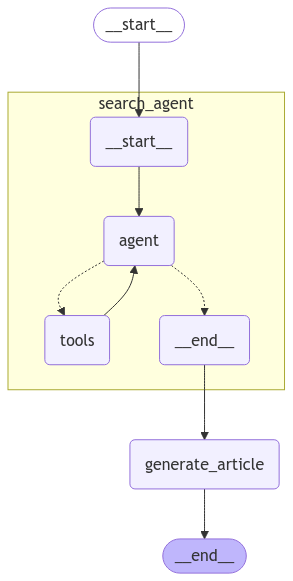

In [39]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))
from IPython.display import Image, display


In [42]:
initial_state = State()
initial_state["content"] = "大谷翔平"


In [43]:
for event in app.stream(initial_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'content': '大谷翔平', 'search_result': '大谷翔平（Ohtani Shohei）は、日本のプロ野球選手であり、メジャーリーグベースボール（MLB）で活躍する二刀流プレーヤーです。彼は1994年7月5日に岩手県で生まれ、花巻東高等学校から2012年に北海道日本ハムファイターズにドラフト1位指名で入団しました。\n\n### 早期キャリア\n大谷は高校時代からその高い程の球速（160km/h）で注目を浴び、プロ入り後は投手・打者としての才能を発揮しました。2013年から2017年まで北海道日本ハムでプレーし、この間には2016年に日本一を経験し、また軽快な打撃と抜群の制球力で多くのタイトルを獲得しました。\n\n### メジャーリーグキャリア\n2018年、大谷はロサンゼルス・エンゼルスに移籍し、大リーグでのデビューを果たしました。デビューシーズンにおいて、彼はアメリカンリーグの新人王に輝き、投打両面での活躍が高く評価されました。特に彼の「二刀流」は近年のプロ野球界でも注目されており、先発投手としても打者としても成果を上げています。\n\n### 成績と受賞歴\n2021年にはアメリカンリーグMVPにも選ばれ、鈴木一朗に次いで日本出身選手としては二人目の栄誉を手にしました。2023年シーズンには44本のホームランを打ち、再びMVPを獲得。彼の巧みな打撃技術とピッチングは、彼を現代のベーブ・ルースと呼ばれるほどの選手としています。\n\n### 2023年の移籍\n2023年12月、大谷はロサンゼルス・ドジャースに移籍し、10年の契約を結びました。この契約は世界のスポーツ史上でも最も高額なものであり、約7億ドルに達しました。移籍後の彼のプレーにも大きな期待が寄せられています。\n\n### 国際舞台での活躍\n彼は日本代表としても活躍し、2023年のワールド・ベースボール・クラシックではチームを優勝に導き、自らもMVPに選出されました。\n\n### 個人生活\n大谷はそのプレースタイルの魅力だけでなく、謙虚で冷静な人柄でも知られています。日本国内外でのブランドアンバサダーとしても活躍しており、様々な企業との契約を結んでいます。\n\n大谷翔平はこれからも野球界での主演としてさらなる高みに挑むことが期待されています。詳しい情報は、[Wik